# Genetic programming

Autores:

- Ana Paula da Silva Pelegrini
- Caio Phillipe Mizerkowski
- Gabriel Protzek

Código: [github](https://github.com/CaioMizerkowski/mestrado/blob/master/EELT7016/trabalho3.ipynb)

## Introdução

Este trabalho realizado para a disciplina EELT7016 tem o objetivo de identificar dois sistemas dinâmicos com comportamento não-linear usando Genetic Programming. Os dados já pré-processados no trabalho 1 sobre do preço da batata e do leite serão usados. Sendo as seguintes bibliotecas utilizadas:


In [1]:
import numpy as np
from deap import base, creator, gp, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from copy import deepcopy as dc
from networkx.drawing.nx_agraph import graphviz_layout
import operator

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


### Problema exemplo

A equação $y_{t}=4+x^2+sin(x_{t-1}^2)+x^3-0.1y_{t-1}^4$ será utilizada como exemplo para demonstrar o funcionamento da biblioteca, para após isso a mesma tecnica ser aplicada aos problemas propostos.


In [2]:
def fun_alvo(x, x_t1, y_t1):
    return 4 + x + np.sin(x_t1) - 0.1 * y_t1


#### Primitivos

Os seguintes primitivos foram adicionados: $+,-,\times,sin$ e constantes.

Como entradas, estão permitidas: $x_t, x_{t-1}, y_{t-1}$.


In [3]:
# Gera os pontos a serem testados

n_x, n_y = 1, 1

pset = gp.PrimitiveSet(name="MAIN", arity=n_x + n_y + 1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.sin, arity=1)
pset.addEphemeralConstant("Constant", lambda: np.round(np.random.uniform(2, 10), 2))


args = {f"ARG{n}": f"x{n}" for n in range(n_x + 1)} | {
    f"ARG{n_x+n+1}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['x0', 'x1', 'y1']

In [4]:
points = np.arange(-10, 10, 0.01)
start_p = max(n_x, n_y)


A função de perda foi a MSE, sendo necessário um loop para usar os valores passados de y.


In [5]:
# Retorna o MSE
def evaluateRegression(individual, points: np.array, pset, fun):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = np.zeros(len(points))
    y_t1_hat = y_t1 = np.random.normal(size=1)

    for n, x in enumerate(points[start_p:]):
        x_t1 = points[start_p + n - 1]

        y = fun(x, x_t1, y_t1)
        y_hat = func(x, x_t1, y_t1_hat)

        y_t1 = np.nan_to_num(y, 0)
        y_t1_hat = np.nan_to_num(y_hat, 0)

        sqerrors[n] = (y_t1 - y_t1_hat) ** 2

    n = len(points)
    np.nan_to_num(sqerrors, 100 * n)
    return (np.sqrt(np.sum(sqerrors) / n),)


É criado o toolbox e adicionadas os métodos de mutação, crossover e seleção.


In [6]:
# Instância a população
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("evaluate", evaluateRegression, points=points, pset=pset, fun=fun_alvo)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=4)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=4)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6)
)


Por fim o processo de treinamento e a conversão da função para um executável. Também sendo reproduzida a árvore de operações para visualização.


In [7]:
pop = toolbox.population(n=20)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=200, verbose=False)
bests = tools.selBest(pop, k=1)
best = bests[0]
print(best)
print(best.fitness)
best_fun = gp.compile(best, pset)


/tmp/ipykernel_941/230345050.py:16: RuntimeWarning: overflow encountered in square
  sqerrors[n] = (y_t1 - y_t1_hat) ** 2
<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: overflow encountered in add
<string>:1: RuntimeWarning: invalid value encountered in add
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in sin
<string>:1: RuntimeWarning: overflow encountered in subtract


add(3.67, add(sin(sin(sin(sin(x1)))), x1))
(0.5156295017647357,)


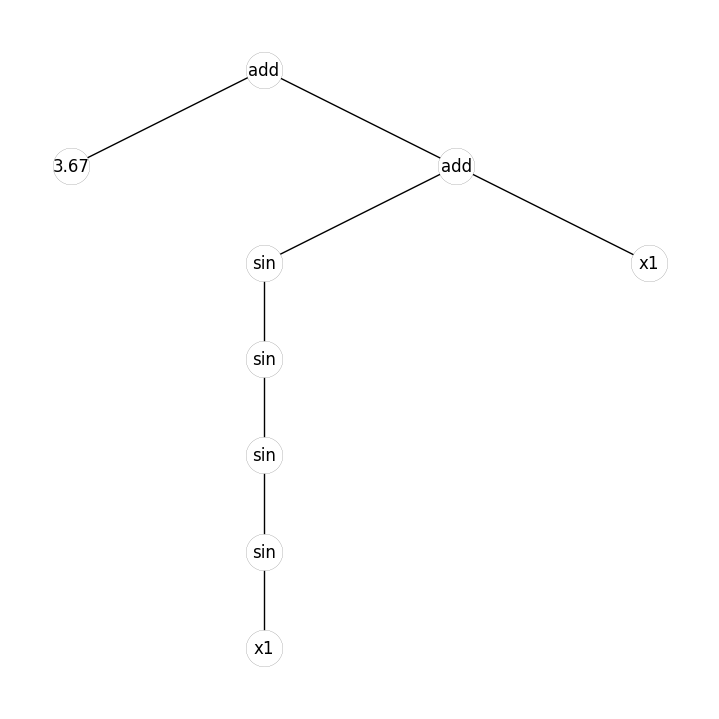

In [8]:
nodes, edges, labels = gp.graph(best)
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

options = {
    "font_size": 30,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.1,
    "width": 1,
}

plt.figure(figsize=(7, 7))
nx.draw(graph, pos, **options)

nx.draw_networkx_labels(graph, pos, labels)
plt.show()


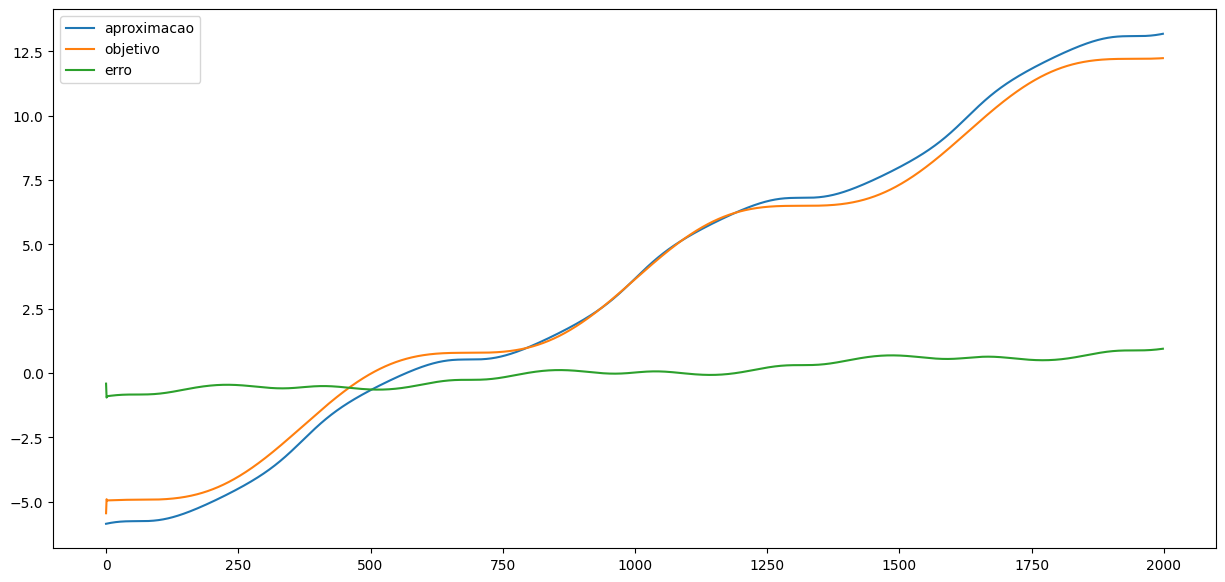

In [9]:
points = np.arange(-10, 10, 0.01)
aproximacao = np.zeros(len(points) - start_p)
objetivo = np.zeros(len(points) - start_p)

y_t1_hat = y_t1 = 0

for n, x in enumerate(points[start_p:]):
    x_t1 = points[start_p + n - 1]

    y = fun_alvo(x, x_t1, y_t1)
    y_hat = best_fun(x, x_t1, y_t1_hat)

    y_t1 = np.nan_to_num(y, 0)
    y_t1_hat = np.nan_to_num(y_hat, 0)

    objetivo[n] = y
    aproximacao[n] = y_hat

erro = aproximacao - objetivo

plt.figure(figsize=(15, 7))
sns.lineplot(data=aproximacao, label="aproximacao")
sns.lineplot(data=objetivo, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


#### Simplificando a árvore

A partir do resultado, podemos simplificar a árvore através de algumas operações. Esse processo não está completo, mas mostra a possibilidade da implementação.


In [10]:
def constantify(value, pset):
    code = f"lambda: {value}"
    new_value = np.round(eval(code, pset.context)(), 2)

    new_constant = gp.Constant()
    new_constant.name = str(new_value)
    new_constant.value = new_value
    return new_constant


In [11]:
def all_constants(b, bs):
    if all(map(lambda x: isinstance(x, gp.Constant), bs)):
        code = b.format(*map(lambda x: x.value, bs))
        new_c = constantify(code, pset)
        # print(f"{code} = {new_c.value}")
        return new_c


def all_terminal(bs):
    return all(map(lambda x: isinstance(x, gp.Terminal), bs))


def add_n_negative2subtract(b, bs):
    if b.name != "add":
        return
    return bs[1].name == "negative"


def duple_negative(b, bs):
    return b.name == "negative" and bs[0] == "negative"


def arg_minus_arg(b, bs):
    return b.name == "subtract" and all_terminal(bs) and bs[0] == bs[1]


def zero_minus_anything(b, bs):
    if b.name != "subtract":
        return
    return all_terminal((bs[0],)) and bs[0].value == 0


def power_zero(b, bs):
    return b.name == "power" and all_terminal((bs[1],)) and bs[1].value == 0


In [12]:
def simplify_tree(best):
    best = dc(best)
    for i, b in enumerate(best):
        if isinstance(b, gp.Primitive):

            bs = []
            J = 1
            for _ in range(1, b.arity + 1):
                bs.append(best[i + J])
                J += len(best[best.searchSubtree(i + J)])

            if new_c := all_constants(b, bs):
                best.pop(i)
                best[i] = new_c

                for _ in range(1, b.arity):
                    best.pop(i + 1)
                return simplify_tree(best)

            if add_n_negative2subtract(b, bs):
                best[i] = pset.mapping["subtract"]
                p = len(best[best.searchSubtree(i + 1)])
                best.pop(i + p + 1)
                return simplify_tree(best)

            if arg_minus_arg(b, bs):
                best.pop(i)
                best[i] = constantify("0", pset)

                for _ in range(1, b.arity):
                    best.pop(i + 1)

                return simplify_tree(best)

            if zero_minus_anything(b, bs):
                print(i)
                print(best[i].name)
                best.pop(i)
                neg = pset.mapping["negative"]
                neg.arity = 0
                best[i] = neg
                neg.arity = 1
                print(best[i].name)
                return simplify_tree(best)

            if power_zero(b, bs):
                best[best.searchSubtree(i)] = [constantify("1", pset)]
                return simplify_tree(best)
    return best


In [13]:
best = simplify_tree(best)
best_fun = gp.compile(best, pset)


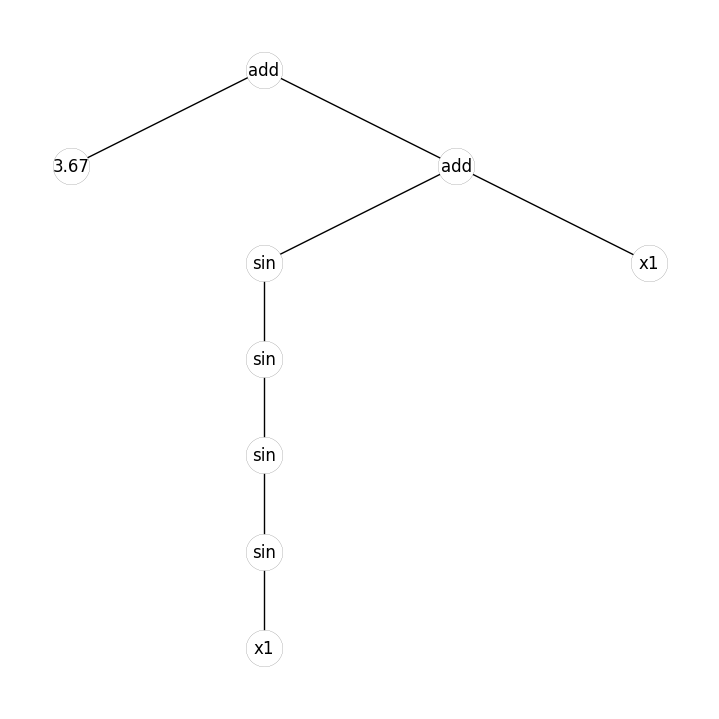

In [14]:
nodes, edges, labels = gp.graph(best)
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

options = {
    "font_size": 30,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.1,
    "width": 1,
}

plt.figure(figsize=(7, 7))
nx.draw(graph, pos, **options)

nx.draw_networkx_labels(graph, pos, labels)
plt.show()


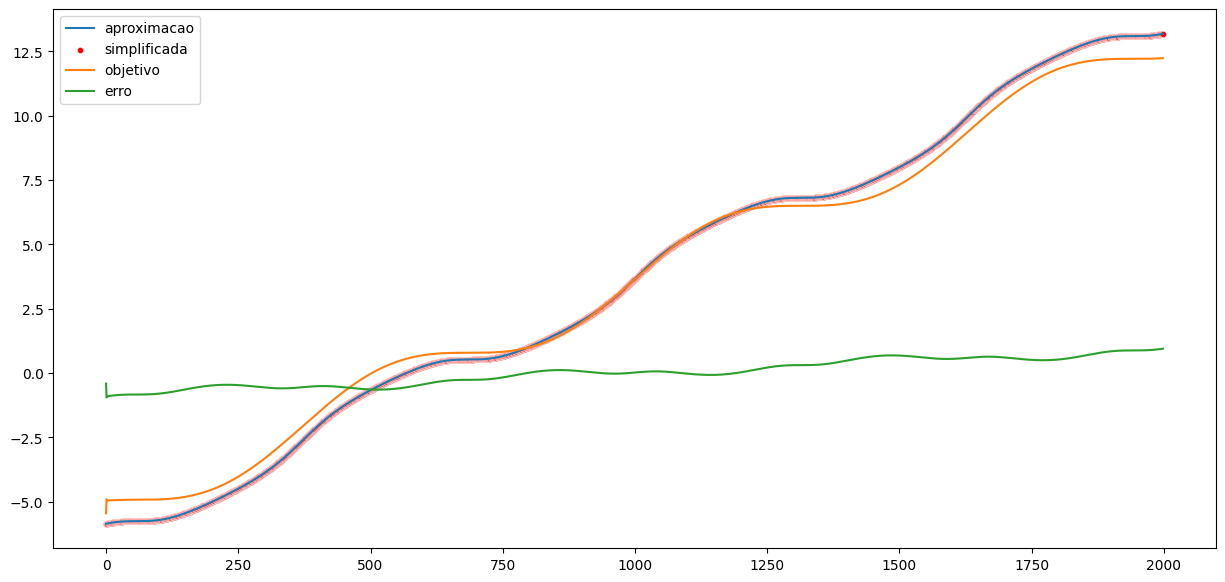

In [15]:
points = np.arange(-10, 10, 0.01)
aproximacao2 = np.zeros(len(points) - start_p)

y_t1_hat = 0

for n, x in enumerate(points[start_p:]):
    x_t1 = points[start_p + n - 1]
    y_hat = best_fun(x, x_t1, y_t1_hat)
    y_t1_hat = np.nan_to_num(y_hat, 0)
    aproximacao2[n] = y_hat

erro = aproximacao2 - objetivo

plt.figure(figsize=(15, 7))
sns.lineplot(data=aproximacao, label="aproximacao")
sns.scatterplot(data=aproximacao2, label="simplificada", color="red", markers=".", s=20)
sns.lineplot(data=objetivo, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.grid()
plt.close()


## Funções


In [16]:
def create_toolbox(evaluate_fun, data, start_point):
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=7)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate_fun, data=data, pset=pset, start_point=start_point)
    toolbox.register("expr_mut", gp.genHalfAndHalf, min_=2, max_=5)

    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.register("select", tools.selTournament, tournsize=5)

    toolbox.decorate(
        "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7)
    )
    toolbox.decorate(
        "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=7)
    )
    return toolbox


In [17]:
def train_population(toolbox):
    pop = toolbox.population(n=100)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000, verbose=False)
    bests = tools.selBest(pop, k=1)
    best = bests[0]
    print(best)
    print(best.fitness)
    best_fun = gp.compile(best, pset)
    return best, best_fun


In [18]:
def show_graph(best):
    best = simplify_tree(best)
    nodes, edges, labels = gp.graph(best)
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    pos = graphviz_layout(graph, prog="dot")

    options = {
        "font_size": 30,
        "node_size": 700,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 0.1,
        "width": 1,
    }

    plt.figure(figsize=(7, 7))
    nx.draw(graph, pos, **options)

    nx.draw_networkx_labels(graph, pos, labels)
    plt.show()


In [19]:
def evaluateRegressionARX2(individual, data: np.ndarray, pset, start_point):
    func = gp.compile(expr=individual, pset=pset)
    y_hat = data.copy()

    for idx, y in enumerate(data[start_point:]):
        y_t1 = data[start_point + idx - 1]
        y_t2 = data[start_point + idx - 2]
        y_hat[start_point + idx] = func(y_t1, y_t2)

    sqerrors = (data - y_hat) ** 2

    for idx, y in enumerate(data[start_point:]):
        y_t1 = np.nan_to_num(y_hat[start_point + idx - 1], 100)
        y_t2 = np.nan_to_num(y_hat[start_point + idx - 2], 100)
        y_hat[start_point + idx] = func(y_t1, y_t2)

    sqerrors += (data - y_hat) ** 2

    np.nan_to_num(np.nan_to_num(sqerrors, 10000))
    n = len(data)*2
    return (np.sqrt(np.sum(sqerrors) / n),)


In [65]:
def evaluateRegressionARX4(individual, data: np.ndarray, pset, start_point):
    func = gp.compile(expr=individual, pset=pset)
    y_hat = data.copy()

    for idx, y in enumerate(data[start_point:]):
        y_t1 = data[start_point + idx - 1]
        y_t2 = data[start_point + idx - 2]
        y_t3 = data[start_point + idx - 3]
        y_t4 = data[start_point + idx - 4]
        y_hat[start_point + idx] = func(y_t1, y_t2, y_t3, y_t4)

    sqerrors = (data - y_hat) ** 2

    for idx, y in enumerate(data[start_point:]):
        y_t1 = np.nan_to_num(y_hat[start_point + idx - 1], 100)
        y_t2 = np.nan_to_num(y_hat[start_point + idx - 2], 100)
        y_t3 = np.nan_to_num(y_hat[start_point + idx - 3], 100)
        y_t4 = np.nan_to_num(y_hat[start_point + idx - 4], 100)
        y_hat[start_point + idx] = func(y_t1, y_t2, y_t3, y_t4)

    sqerrors = (data - y_hat) ** 2

    np.nan_to_num(sqerrors, 100)
    n = len(data)
    return (np.sqrt(np.sum(sqerrors) / n),)


## Primeiro Sistema - Preço do Leite


In [21]:
data = np.loadtxt("leite.csv", delimiter=";")[:, 1]


#### ARX 2


In [22]:
# Gera os pontos a serem testados

n_x, n_y = 0, 2
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="ARX-2", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addEphemeralConstant(
    "Constant-arx-2", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2']

In [23]:
toolbox = create_toolbox(evaluateRegressionARX2, data, start_point)


In [24]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: invalid value encountered in add
<string>:1: RuntimeWarning: invalid value encountered in subtract
/tmp/ipykernel_941/498075756.py:17: RuntimeWarning: overflow encountered in square
  sqerrors += (data - y_hat) ** 2
<string>:1: RuntimeWarning: overflow encountered in add
<string>:1: RuntimeWarning: invalid value encountered in multiply
<string>:1: RuntimeWarning: overflow encountered in subtract
/home/caio/.pyenv/versions/3.10.6/envs/PyTorch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


subtract(y1, multiply(subtract(subtract(4.1, y1), add(add(subtract(add(2.02, y1), add(y1, 8.29)), add(subtract(y1, 6.86), subtract(y2, y1))), add(y1, 3.42))), multiply(subtract(y1, y1), subtract(subtract(y1, subtract(multiply(y2, y1), subtract(y2, y2))), subtract(6.2, y1)))))
(0.5708521992381215,)


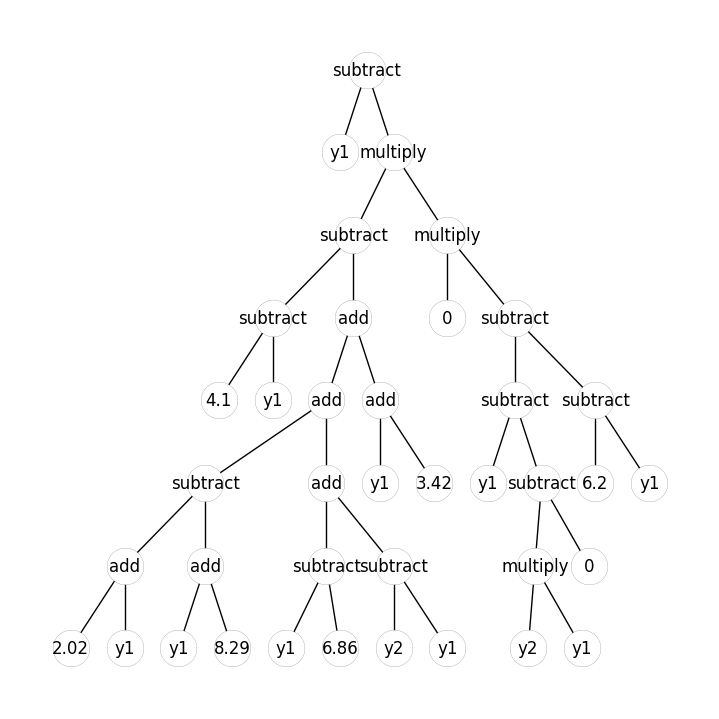

In [26]:
show_graph(best)


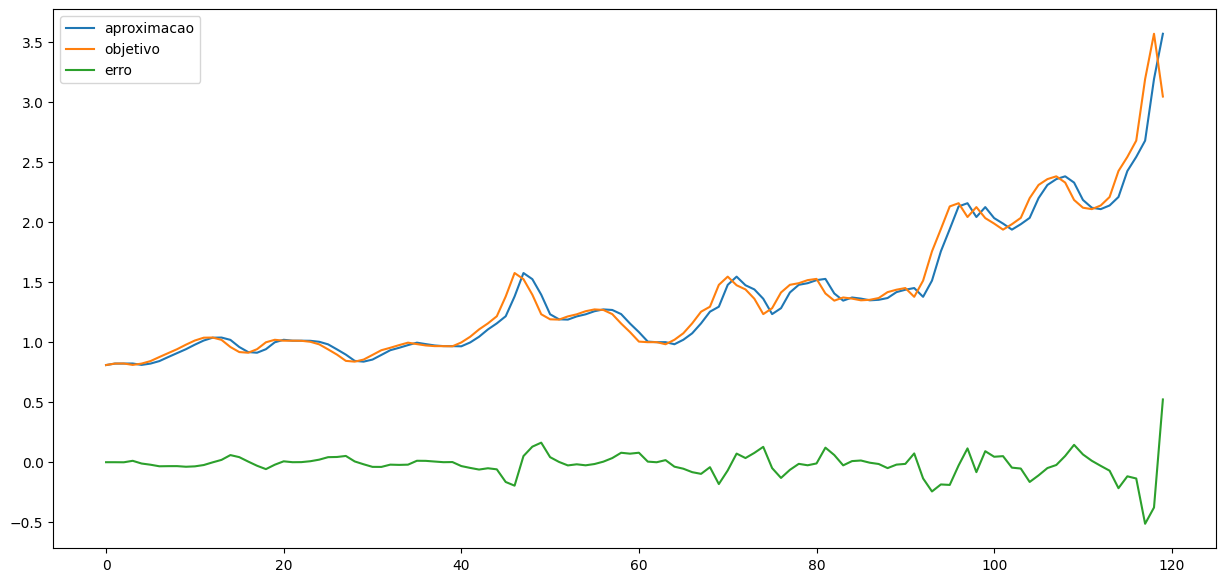

In [27]:
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


#### ARX 4


In [28]:
n_x, n_y = 0, 4
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="ARX-4", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addEphemeralConstant(
    "Constant-arx-4", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2', 'y3', 'y4']

In [29]:
toolbox = create_toolbox(evaluateRegressionARX4, data, start_point)


In [30]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: overflow encountered in add
/tmp/ipykernel_941/149955666.py:21: RuntimeWarning: overflow encountered in square
  sqerrors = (data - y_hat) ** 2
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in multiply
<string>:1: RuntimeWarning: invalid value encountered in add
<string>:1: RuntimeWarning: overflow encountered in subtract
/home/caio/.pyenv/versions/3.10.6/envs/PyTorch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


subtract(y3, add(add(multiply(y2, y2), multiply(y2, y2)), add(y3, add(subtract(subtract(8.9, multiply(y1, y4)), y4), add(multiply(y3, multiply(y2, y3)), add(7.96, y4))))))
(nan,)


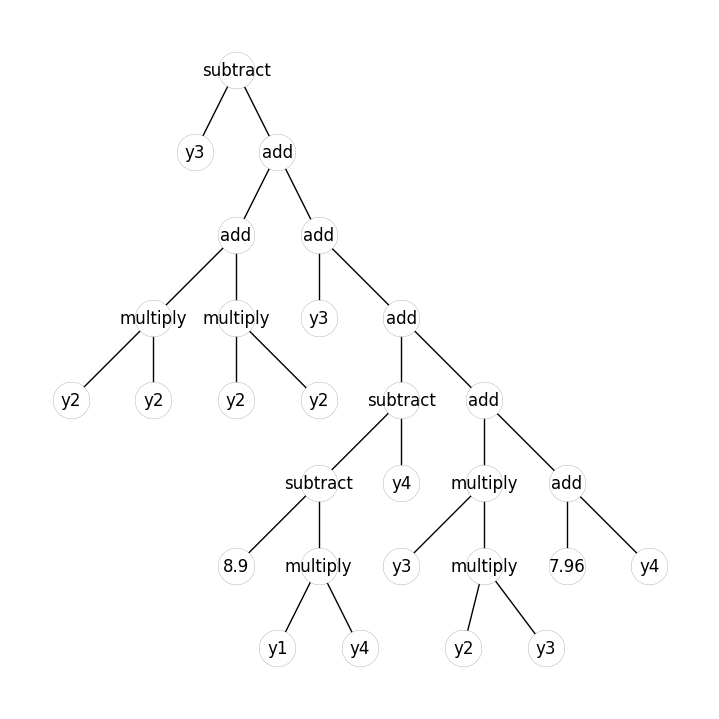

In [31]:
show_graph(best)


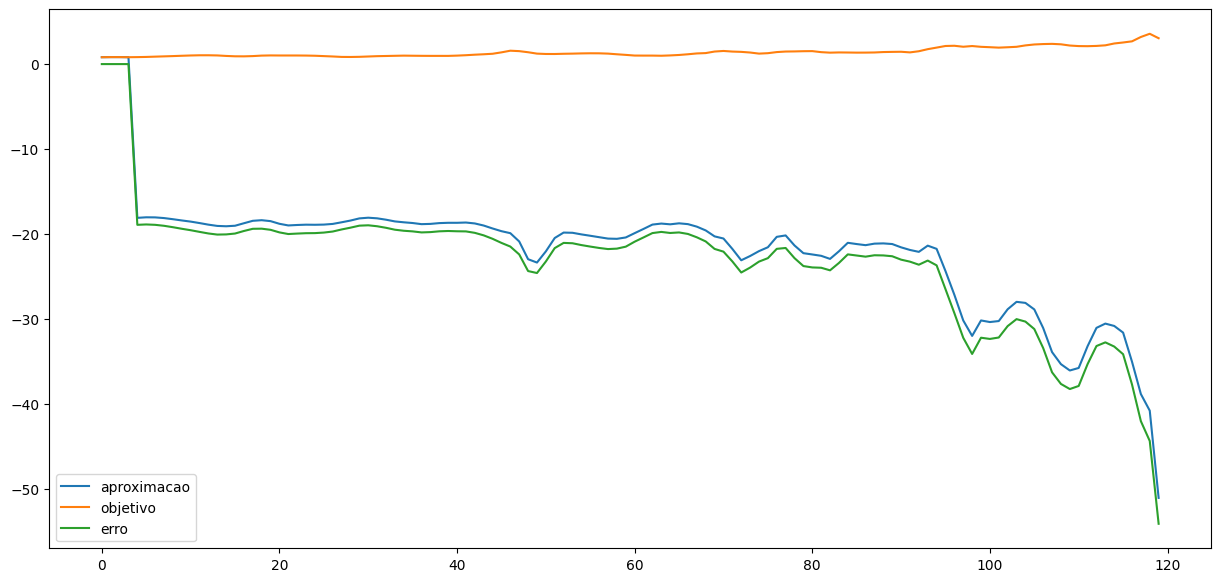

In [32]:
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_t3 = data[start_point + idx - 3]
    y_t4 = data[start_point + idx - 4]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2, y_t3, y_t4)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


#### NARX 2


In [33]:
n_x, n_y = 0, 2
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="NARX-2", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addEphemeralConstant(
    "Constant-narx-2", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2']

In [34]:
toolbox = create_toolbox(evaluateRegressionARX2, data, start_point)


In [35]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_941/498075756.py:17: RuntimeWarning: overflow encountered in square
  sqerrors += (data - y_hat) ** 2
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: overflow encountered in add
<string>:1: RuntimeWarning: invalid value encountered in add
<string>:1: RuntimeWarning: invalid value encountered in cos
<string>:1: RuntimeWarning: invalid value encountered in sin
<string>:1: RuntimeWarning: overflow encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in multiply


subtract(2.22, cos(subtract(cos(cos(subtract(subtract(y2, 2.22), subtract(y1, y1)))), y1)))
(0.309467927581758,)


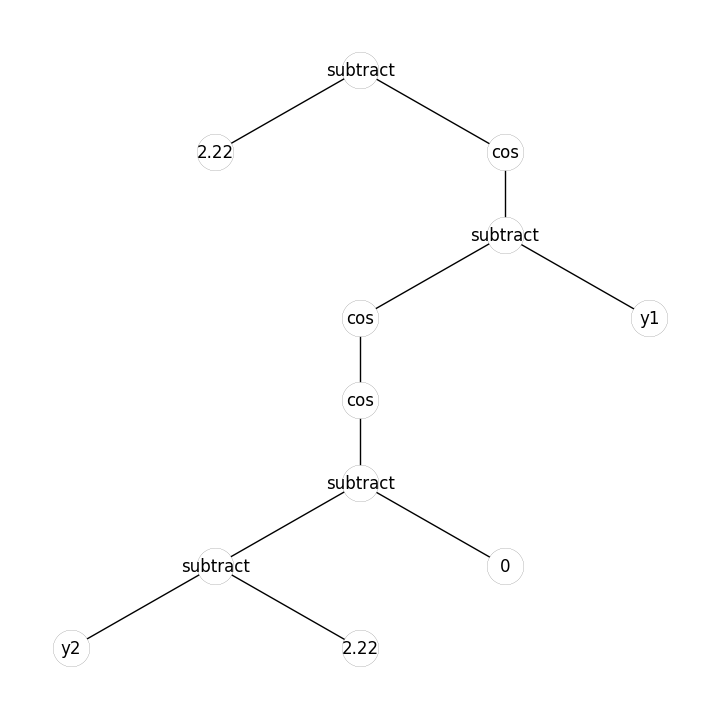

In [36]:
show_graph(best)


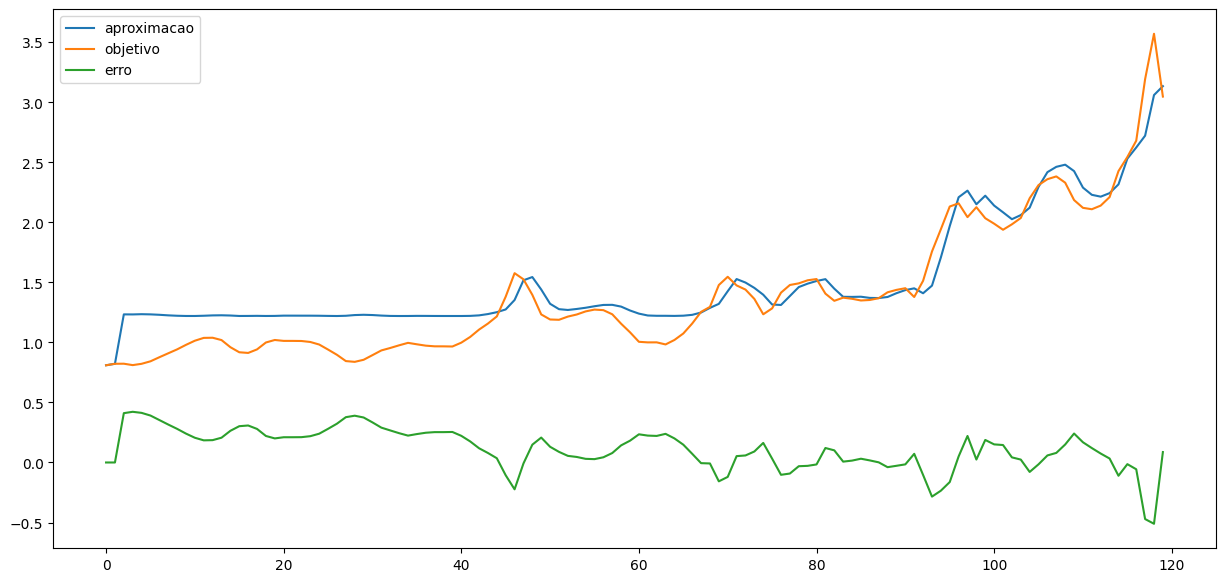

In [37]:
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


#### NARX 4


In [38]:
n_x, n_y = 0, 4
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="NARX-4", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addEphemeralConstant(
    "Constant-narx-4", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2', 'y3', 'y4']

In [39]:
toolbox = create_toolbox(evaluateRegressionARX4, data, start_point)


In [40]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: overflow encountered in add
<string>:1: RuntimeWarning: overflow encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in cos
<string>:1: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_941/149955666.py:21: RuntimeWarning: overflow encountered in square
  sqerrors = (data - y_hat) ** 2
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in sin
<string>:1: RuntimeWarning: invalid value encountered in add


add(sin(subtract(y3, cos(cos(multiply(y3, subtract(y3, y3)))))), cos(sin(add(subtract(add(y2, y3), cos(2.41)), multiply(y2, sin(cos(3.2)))))))
(0.31194400420775314,)


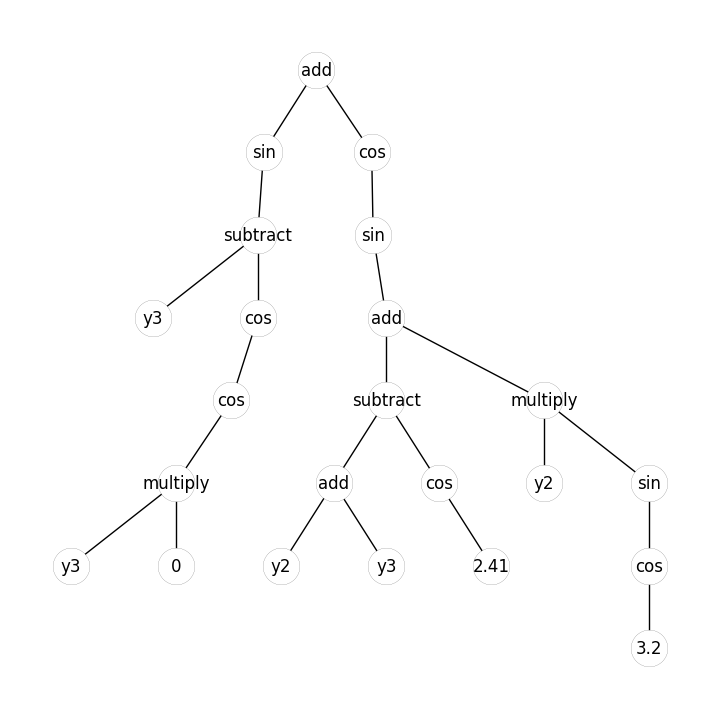

In [41]:
show_graph(best)


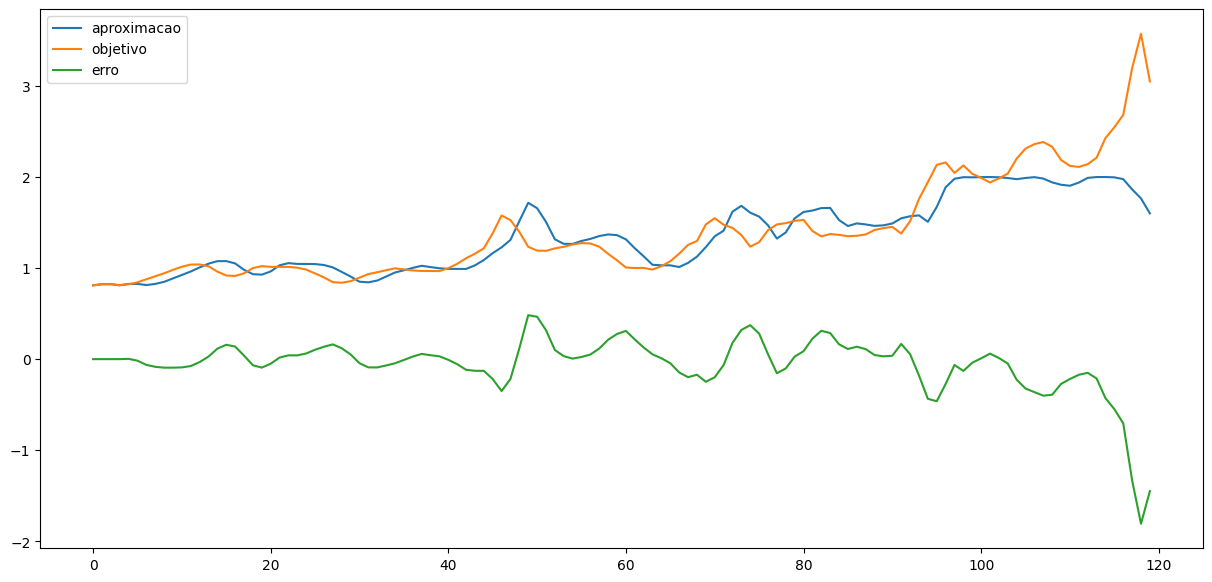

In [42]:
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_t3 = data[start_point + idx - 3]
    y_t4 = data[start_point + idx - 4]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2, y_t3, y_t4)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


## Segundo Sistema - Preço da Batata


In [ ]:
batata = np.loadtxt("batata.csv", delimiter=";")[:, 1]

#### ARX 2


In [46]:
# Gera os pontos a serem testados

n_x, n_y = 0, 2
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="ARX-2-b", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addEphemeralConstant(
    "Constant-arx-2-b", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2']

In [47]:
toolbox = create_toolbox(evaluateRegressionARX2, data, start_point)


In [48]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: overflow encountered in add
/tmp/ipykernel_941/498075756.py:17: RuntimeWarning: overflow encountered in square
  sqerrors += (data - y_hat) ** 2
<string>:1: RuntimeWarning: overflow encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in multiply
<string>:1: RuntimeWarning: invalid value encountered in add
/home/caio/.pyenv/versions/3.10.6/envs/PyTorch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


add(multiply(add(subtract(y1, subtract(y2, y1)), multiply(subtract(3.15, y2), add(y1, y2))), subtract(multiply(subtract(multiply(7.23, y2), multiply(y2, y2)), 7.76), y1)), y1)
(nan,)


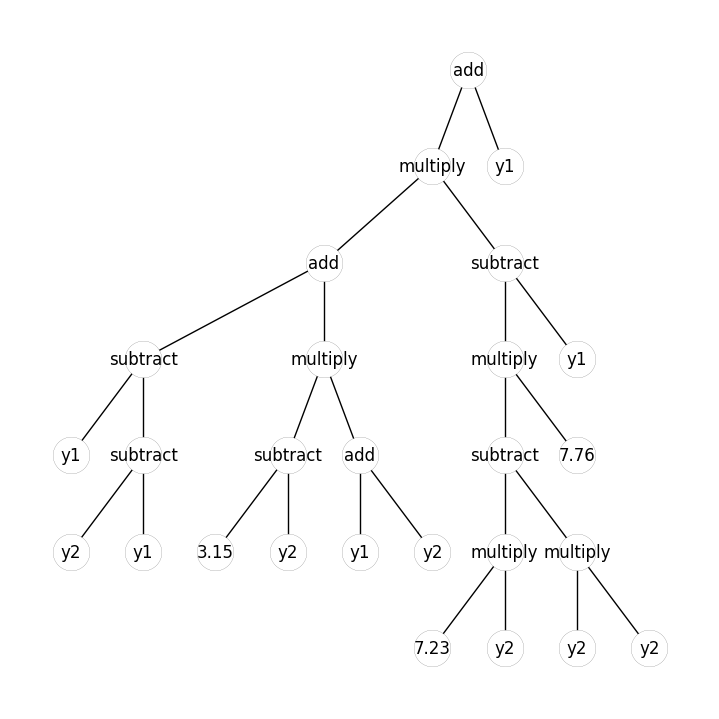

In [49]:
show_graph(best)


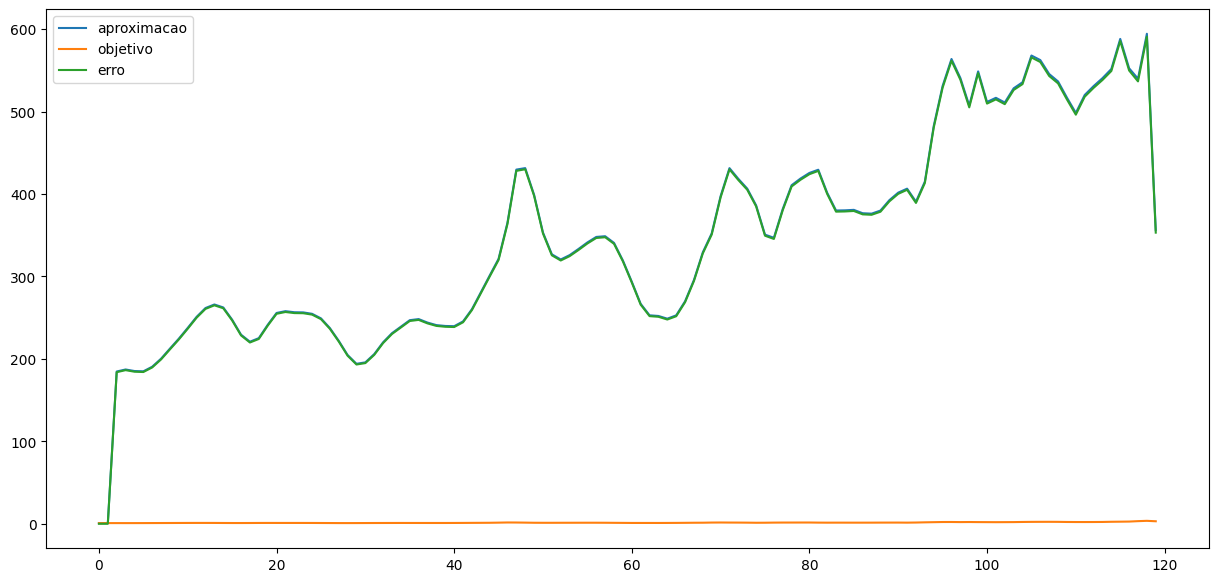

In [50]:
data = data
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


#### ARX 4

In [51]:
n_x, n_y = 0, 4
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="ARX-4-b", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addEphemeralConstant(
    "Constant-arx-4-b", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2', 'y3', 'y4']

In [52]:
toolbox = create_toolbox(evaluateRegressionARX4, data, start_point)


In [53]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: invalid value encountered in multiply
<string>:1: RuntimeWarning: overflow encountered in subtract
<string>:1: RuntimeWarning: overflow encountered in add
<string>:1: RuntimeWarning: invalid value encountered in add
<string>:1: RuntimeWarning: invalid value encountered in subtract
/tmp/ipykernel_941/149955666.py:21: RuntimeWarning: overflow encountered in square
  sqerrors = (data - y_hat) ** 2


add(subtract(multiply(multiply(y4, 3.91), y4), add(y2, y3)), y3)
(nan,)


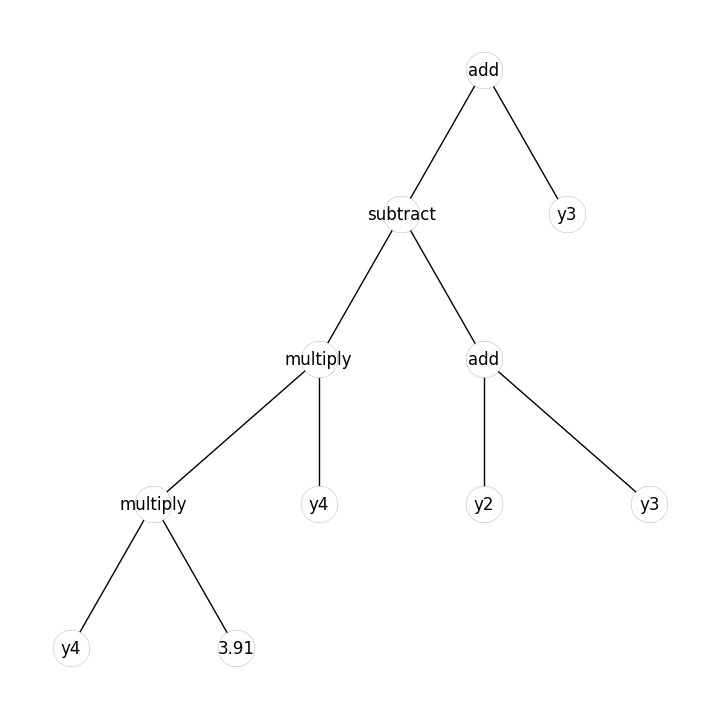

In [54]:
show_graph(best)


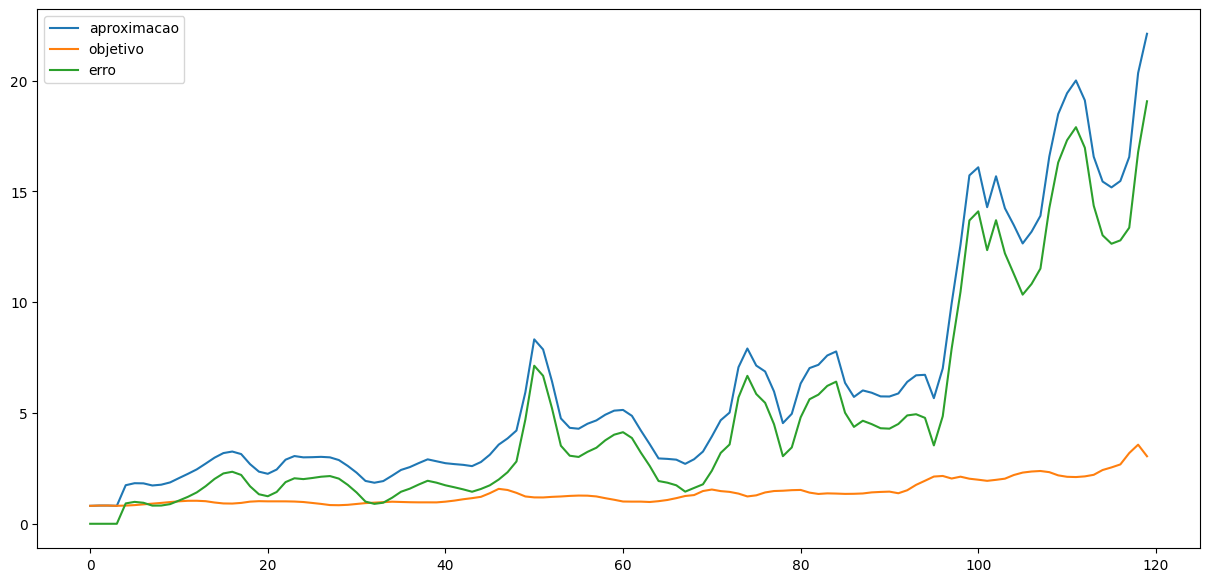

In [55]:
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_t3 = data[start_point + idx - 3]
    y_t4 = data[start_point + idx - 4]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2, y_t3, y_t4)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


#### NARX 2


In [56]:
n_x, n_y = 0, 2
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="NARX-2-b", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addEphemeralConstant(
    "Constant-narx-2-b", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2']

In [57]:
toolbox = create_toolbox(evaluateRegressionARX2, data, start_point)


In [58]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: invalid value encountered in cos
<string>:1: RuntimeWarning: overflow encountered in add
<string>:1: RuntimeWarning: invalid value encountered in add
/tmp/ipykernel_941/498075756.py:17: RuntimeWarning: overflow encountered in square
  sqerrors += (data - y_hat) ** 2
<string>:1: RuntimeWarning: overflow encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in sin
<string>:1: RuntimeWarning: invalid value encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in multiply


subtract(add(add(cos(y1), y1), cos(add(y1, cos(y2)))), multiply(cos(subtract(sin(sin(sin(3.29))), multiply(subtract(cos(y1), sin(4.75)), subtract(y2, y1)))), cos(y1)))
(0.3193103273228035,)


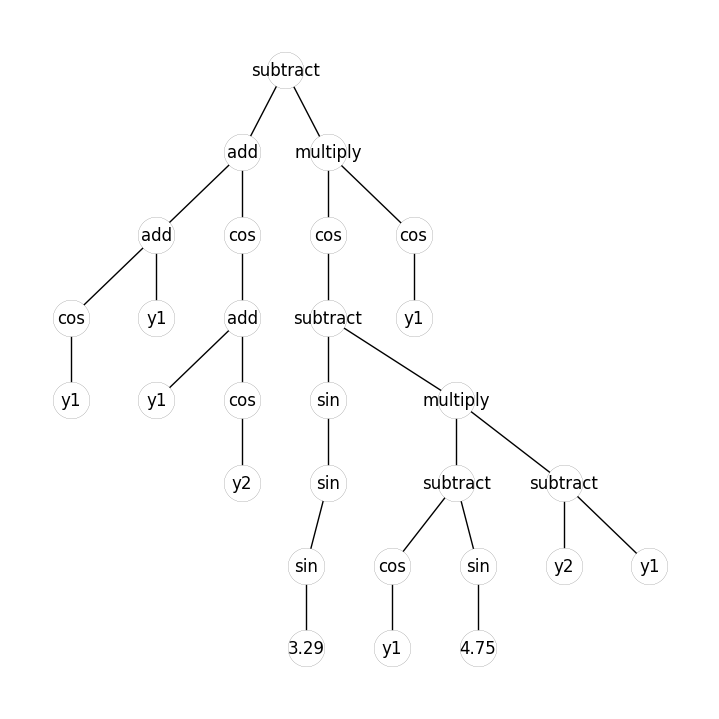

In [59]:
show_graph(best)


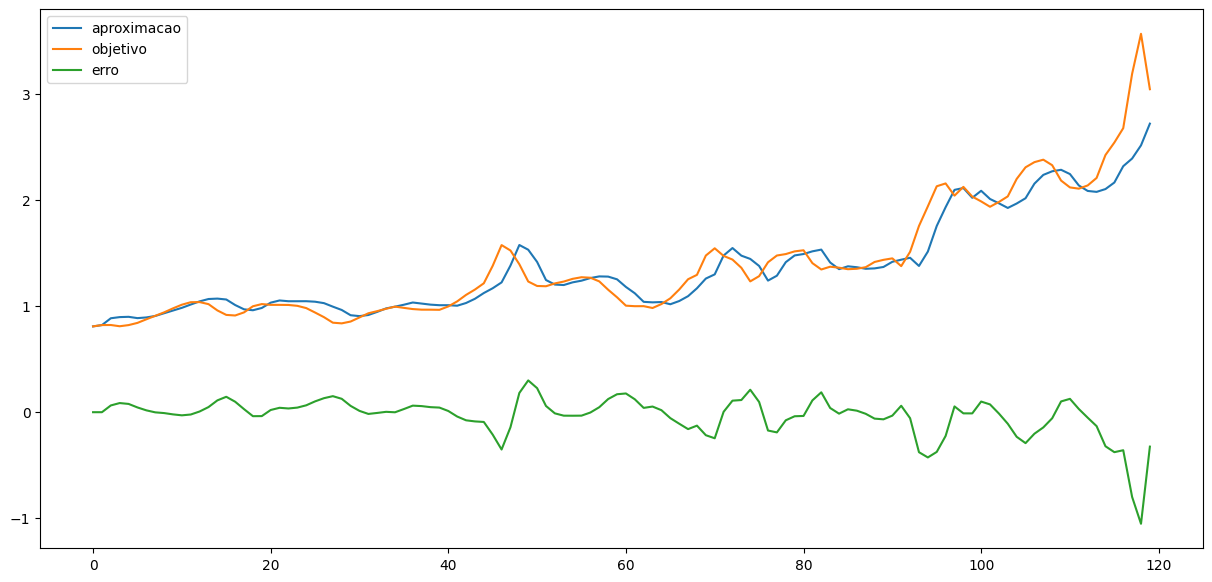

In [60]:
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


#### NARX 4


In [61]:
n_x, n_y = 0, 4
start_point = max(n_x, n_y)
pset = gp.PrimitiveSet(name="NARX-4-b", arity=n_x + n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addEphemeralConstant(
    "Constant-narx-4-b", lambda: np.round(np.random.uniform(2, 10), 2)
)


args = {f"ARG{n}": f"x{n+1}" for n in range(n_x)} | {
    f"ARG{n_x+n}": f"y{n+1}" for n in range(n_y)
}

pset.renameArguments(**args)
pset.arguments


['y1', 'y2', 'y3', 'y4']

In [66]:
toolbox = create_toolbox(evaluateRegressionARX4, data, start_point)


In [67]:
best, best_fun = train_population(toolbox)


<string>:1: RuntimeWarning: overflow encountered in multiply
<string>:1: RuntimeWarning: overflow encountered in add
/tmp/ipykernel_941/149955666.py:21: RuntimeWarning: overflow encountered in square
  sqerrors = (data - y_hat) ** 2
<string>:1: RuntimeWarning: invalid value encountered in add
<string>:1: RuntimeWarning: invalid value encountered in multiply
<string>:1: RuntimeWarning: invalid value encountered in cos
<string>:1: RuntimeWarning: invalid value encountered in sin
<string>:1: RuntimeWarning: overflow encountered in subtract
<string>:1: RuntimeWarning: invalid value encountered in subtract


subtract(multiply(add(subtract(cos(y4), sin(y4)), multiply(subtract(y4, y1), add(subtract(y2, y4), y2))), cos(subtract(multiply(y4, add(2.13, 6.02)), subtract(y3, y1)))), cos(multiply(subtract(sin(subtract(y2, y4)), sin(sin(y4))), cos(subtract(6.55, 9.86)))))
(nan,)


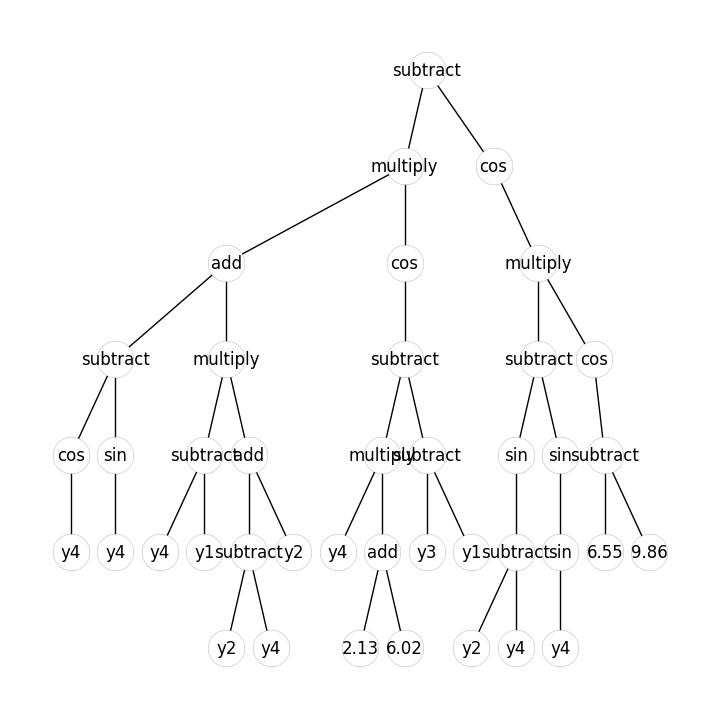

In [68]:
show_graph(best)


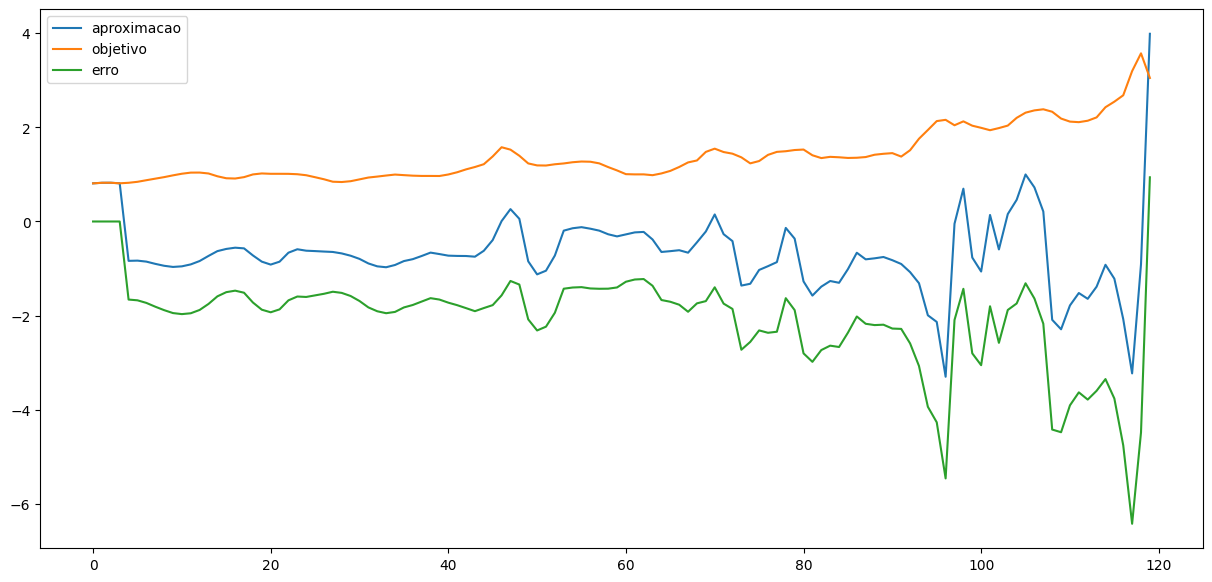

In [69]:
y_hat = data.copy()

for idx, y in enumerate(data[start_point:]):
    y_t1 = data[start_point + idx - 1]
    y_t2 = data[start_point + idx - 2]
    y_t3 = data[start_point + idx - 3]
    y_t4 = data[start_point + idx - 4]
    y_hat[start_point + idx] = best_fun(y_t1, y_t2, y_t3, y_t4)

erro = y_hat - data

plt.figure(figsize=(15, 7))
sns.lineplot(data=y_hat, label="aproximacao")
sns.lineplot(data=data, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


## Resultados

Para o preço do leite, o MSE foi:
- ARX 2 : 0.57
- ARX 4 : Não convergiu
- NARX 2: 0.31
- NARX 4: 0.31

Para o preço do leite, o MSE foi:
- ARX 2 : Não convergiu
- ARX 4 : Não convergiu
- NARX 2: 0.32
- NARX 4: Não convergiu

As não convergência ocorreram em razão de operações que geraram NaN durante o processo, como gerar números muito grandes internamente e causar um overflow.